In [1]:
from utils import *
import numpy as np
from rmt_results import *
from plot_utils import *
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dataset import *

/Users/aelfirdo/Desktop/Research/TII/Noisy labels/rmt-noisy-labels/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Testing Amazon review dataset

In [1]:
# 
import numpy as np
class_to_path = {
    'book': './datasets/Amazon_review/books.mat',
    'dvd': './datasets/Amazon_review/dvd.mat',
    'elec': './datasets/Amazon_review/elec.mat',
    'kitchen': './datasets/Amazon_review/kitchen.mat',
}
from scipy.io import loadmat
data = loadmat(class_to_path['book'])

In [4]:
data['fts'].shape

(2000, 400)

In [5]:
data['labels'].shape

(2000, 1)

In [12]:
sorted_arr = sorted(data['labels'], reverse= True)
(data['labels'] == sorted_arr).all()

True

In [25]:
y = data['labels']
y = y.reshape((len(y), ))
y.shape


(2000,)

In [38]:
y = y.astype(int)
y

array([1, 1, 1, ..., 0, 0, 0])

In [39]:
1 - 2 * y

array([-1, -1, -1, ...,  1,  1,  1])

In [46]:
X = data['fts']
X

array([[0.        , 0.02941176, 0.02941176, ..., 0.        , 0.        ,
        0.        ],
       [0.03030303, 0.        , 0.06060606, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04166667, 0.04166667, 0.04166667, ..., 0.        , 0.        ,
        0.        ],
       [0.02380952, 0.0952381 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02380952, 0.        , 0.04761905, ..., 0.        , 0.        ,
        0.        ]])

In [47]:
X.astype(float)

array([[0.        , 0.02941176, 0.02941176, ..., 0.        , 0.        ,
        0.        ],
       [0.03030303, 0.        , 0.06060606, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04166667, 0.04166667, 0.04166667, ..., 0.        , 0.        ,
        0.        ],
       [0.02380952, 0.0952381 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02380952, 0.        , 0.04761905, ..., 0.        , 0.        ,
        0.        ]])

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
X_train.shape

(1600, 400)

In [51]:
y_train.shape

(1600,)

In [1]:
import dataset
epsp = 0.2
epsm = 0.1
type = 'elec'
amazon = dataset.Amazon(epsp, epsm, type= type, pi = 0.3, n = 1500)

In [2]:
amazon.y_train.shape

(1500,)

In [3]:
import numpy as np
np.mean((amazon.y_train > 0))

0.7

In [4]:
X_test = amazon.X_test
X_test.shape

(1008, 400)

## Test optimizing on $\rho$ out of the interval (0, 1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rmt_results import *
from utils import *
from tqdm.auto import tqdm

/Users/aelfirdo/Desktop/Research/TII/Noisy labels/rmt-noisy-labels/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def func(n, p, epsp, epsm, rhop, rhom, mu, gamma, pi):
    classifier = 'improved'
 
    # E[g] and E[g^2]
    mean = test_expectation(classifier, n, p, pi, epsp, epsm, rhop, rhom, mu, gamma)
    expec_2 = test_expectation_2(classifier, pi, n, p, epsp, epsm, rhop, rhom, mu, gamma)
    std = np.sqrt(expec_2 - mean**2)
    acc = 1-integrate.quad(lambda x: utils.gaussian(x, 0, 1), abs(mean)/std, np.inf)[0]
    ratio = abs(mean) / std
    return acc, ratio

In [18]:
# Parameters
n = 1000
p = 1000
epsp = 0.3
epsm = 0.45
rhom = 0.5
mu = 2
gamma = 1e2
pi = .3
N = 1000
rhops = np.linspace(-10, 10, N)
accs = []
ratios = []
for rhop in tqdm(rhops):
    #rhom = rhop
    a, r = func(n, p, epsp, epsm, rhop, rhom, mu, gamma, pi)
    accs.append(a)
    ratios.append(r)

100%|██████████| 1000/1000 [00:00<00:00, 6180.94it/s]


0.8963849459087461


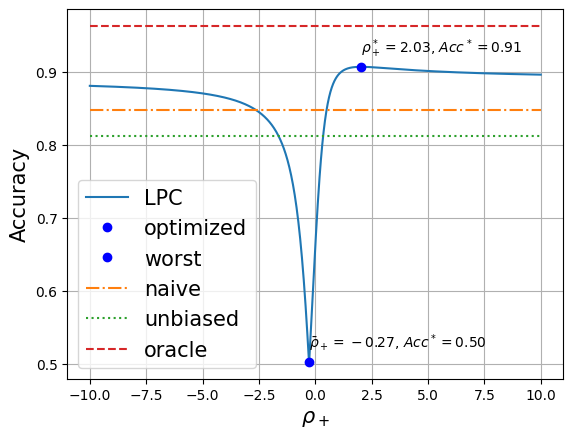

In [19]:
fontsize = 15
plt.plot(rhops, accs, label='LPC');
plt.plot(rhops[np.argmax(accs)], np.max(accs), 'bo', label='optimized')
plt.plot(rhops[np.argmin(accs)], np.min(accs), 'bo', label='worst')
nai, _ = func(n, p, epsp, epsm, 0, 0, mu, gamma, pi)
plt.plot([-10, 10], [nai, nai], '-.', label='naive')
unb, _ = func(n, p, epsp, epsm, epsp, epsm, mu, gamma, pi)
plt.plot([-10, 10], [unb, unb], ':', label='unbiased')
ora, _ = func(n, p, 0, 0, 0, 0, mu, gamma, pi)
plt.plot([-10, 10], [ora, ora], '--', label='oracle')
plt.xlabel(r'$\rho_+$', fontsize=fontsize);
plt.ylabel('Accuracy', fontsize=fontsize);
plt.legend(fontsize=fontsize);
np.max(accs)
plt.grid('on')
x, y = rhops[np.argmax(accs)], np.max(accs)
s = '$\\rho_+^*=%.2f$, $Acc^*=%.2f$' % (x, y)
plt.text(x+1e-2, y+2e-2, s)
x, y = rhops[np.argmin(accs)], np.min(accs)
s = '$\\bar \\rho_+=%.2f$, $Acc^*=%.2f$' % (x, y)
plt.text(x+1e-2, y+2e-2, s)
print(accs[-1])
plt.show()

## Now simulating on real dataset

In [6]:
from utils import *
from rmt_results import *
from tqdm.auto import tqdm
from dataset import *

In [10]:
# Parameters
n = 1600
p = 400
pi = 0.4
epsp = 0.5
epsm = 0.4
rhom = epsm
gamma = 100
batch = 50
metric = 'accuracy'

# real dataset
data_type = 'book'
data_name = 'amazon_' + data_type
data = Amazon(epsp, epsm, data_type, pi, n)
mu = data.mu

rhops = np.linspace(-10, 10, 20)
accs = []
rhop_, rhom = 
for rhop in tqdm(rhops):
    accs.append(empirical_accuracy('improved', batch, n, p, mu, epsp, epsm, rhop, rhom, gamma, pi, data_name))


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


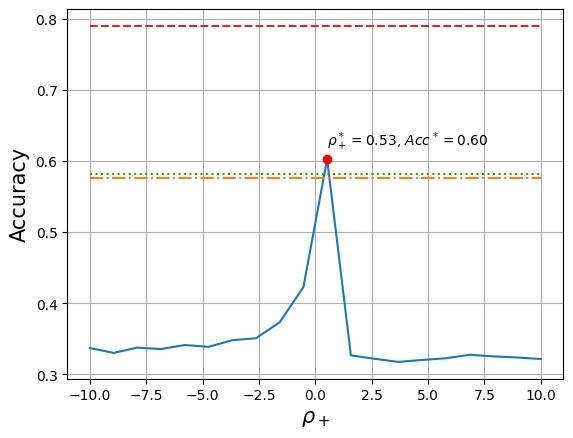

In [11]:
fontsize = 15
plt.plot(rhops, accs, label='LPC');
plt.plot(rhops[np.argmax(accs)], np.max(accs), 'ro', label='optimized')
nai= empirical_accuracy('naive', batch, n, p, mu, epsp, epsm, 0, 0, gamma, pi, data_name)
plt.plot([-10, 10], [nai, nai], '-.', label='naive')
unb = empirical_accuracy('naive', batch, n, p, mu, epsp, epsm, epsp, epsm, gamma, pi, data_name)
plt.plot([-10, 10], [unb, unb], ':', label='unbiased')
ora = empirical_accuracy('naive', batch, n, p, mu, 0, 0, 0, 0, gamma, pi, data_name)
plt.plot([-10, 10], [ora, ora], '--', label='oracle')
plt.xlabel(r'$\rho_+$', fontsize=fontsize);
plt.ylabel('Accuracy', fontsize=fontsize);
#plt.legend(fontsize=fontsize);
np.max(accs)
plt.grid('on')
x, y = rhops[np.argmax(accs)], np.max(accs)
s = '$\\rho_+^*=%.2f$, $Acc^*=%.2f$' % (x, y)
plt.text(x+1e-2, y+2e-2, s)
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Noisy labels/rmt-noisy-labels/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 200/200 [00:09<00:00, 22.02it/s]


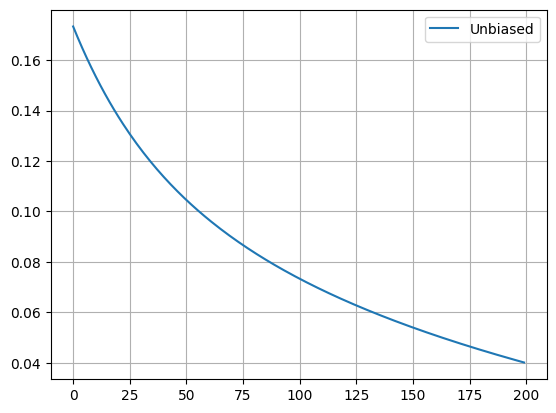

In [1]:
import numpy as np
from utils import *
from plot_utils import *
from train_bce import *
from tqdm.auto import tqdm

lr = 0.1
gamma = 0
mu = 1
n = 2000
p = 200
pi = 0.3
epsm = 0.2
epsp = 0.3


# Training Unbiased
#epsps = np.linspace(0, 7, 8) / 10

# Generate a dataset
fix_seed(123)
(X_train, y_train, y_train_noisy), (X_test, y_test) = generate_data(p, n, epsp, epsm,mu, pi)
w_unb = np.zeros(X_train.shape[0])

X = X_train.T
y = y_train_noisy
N = 200
losses_unb = []
for k in tqdm(range(N)):
    loss = 0
    grad_step = 0
    for i in range(n):
        grad_step += improved_bce_grad(w_unb, X[i], y[i], epsp, epsm) / n
        loss += improved_bce_loss(w_unb, X[i], y[i], epsp, epsm) / n 
    loss += gamma * np.sum(w_unb**2)
    losses_unb.append(loss)
    # step
    w_unb = (1 - 2 * gamma) * w_unb - lr * grad_step 

t = np.arange(0, N)
plt.plot(t, losses_unb, label = 'Unbiased')
plt.grid()
plt.legend()
plt.show()


In [2]:
# Training Optimized
w_lpa = np.zeros(X_train.shape[0])
rhop, rhom = optimal_rhos(pi, epsp, epsm)
losses_lpa = []
for k in tqdm(range(N)):
    loss = 0
    grad_step = 0
    for i in range(n):
        grad_step += improved_bce_grad(w_lpa, X[i], y[i], rhop, rhom) / n
        loss += improved_bce_loss(w_lpa, X[i], y[i], rhop, rhom) / n 
    loss += gamma * np.sum(w_lpa**2)
    losses_lpa.append(loss)
    # step
    w_lpa = (1 - 2 * gamma) * w_lpa - lr * grad_step 


100%|██████████| 200/200 [00:09<00:00, 21.34it/s]


In [3]:
# Training Naive
w_naive = np.zeros(X_train.shape[0])
losses_naive = []
for k in tqdm(range(N)):
    loss = 0
    grad_step = 0
    for i in range(n):
        grad_step += improved_bce_grad(w_naive, X[i], y[i], 0, 0) / n
        loss += improved_bce_loss(w_naive, X[i], y[i], 0, 0) / n 
    loss += gamma * np.sum(w_naive**2)
    losses_naive.append(loss)
    # step
    w_naive = (1 - 2 * gamma) * w_naive - lr * grad_step 

100%|██████████| 200/200 [00:09<00:00, 21.27it/s]


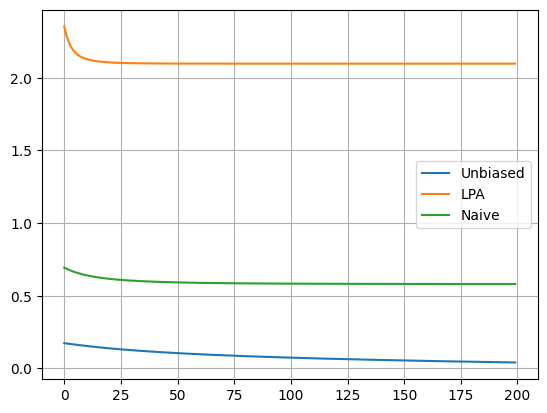

In [4]:
t = np.arange(0, N)
plt.plot(t, losses_unb, label = 'Unbiased')
plt.plot(t, losses_lpa, label = 'LPA')
plt.plot(t, losses_naive, label = 'Naive')
plt.grid()
plt.legend()
plt.show()

In [5]:
# Compare test accuracies:
print('Unbiased', accuracy(decision(w_unb, X_test), y_test))
print('Naive', accuracy(decision(w_naive, X_test), y_test))
print('LPC', accuracy(decision(w_lpa, X_test), y_test))


Unbiased 0.77075
Naive 0.72325
LPC 0.74475


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rmt_results import *
from utils import *
from tqdm.auto import tqdm
from train_bce import *

/Users/aelfirdo/Desktop/Research/TII/Noisy labels/rmt-noisy-labels/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Let us now do the accuracy of LPC in function of rhop
def grad_descent(X, y, lr, gamma, rhop, rhom, N):
    # X of shape (n, p)
    n, p = X.shape
    w = np.zeros(p)
    losses = []
    for k in range(N):
        loss = 0
        grad_step = 0
        for i in range(n):
            grad_step += improved_bce_grad(w, X[i], y[i], rhop, rhom) / n
            loss += improved_bce_loss(w, X[i], y[i], rhop, rhom) / n 
        loss += gamma * np.sum(w**2)
        losses.append(loss)
        # step
        w = (1 - 2 * gamma) * w - lr * grad_step 
    return w, losses


In [5]:
# Parameters
n = 1000
p = 1000
pi = 0.3
epsp = 0.4
epsm = 0.3
mu = 2
gamma = 0
rhom = 0
rhops = np.linspace(-2, 2, 50)

# Dataset
#fix_seed(123)
(X_train, y_train, y_train_noisy), (X_test, y_test) = generate_data(p, n, epsp, epsm,mu, pi)
X = X_train.T
y = y_train_noisy

lr = 0.1
N = 50
accs = []
for rhop in tqdm(rhops):
    w, losses = grad_descent(X, y, lr, gamma, rhop, rhom, N)
    accs.append(accuracy(decision(w, X_test), y_test))


100%|██████████| 50/50 [01:22<00:00,  1.64s/it]


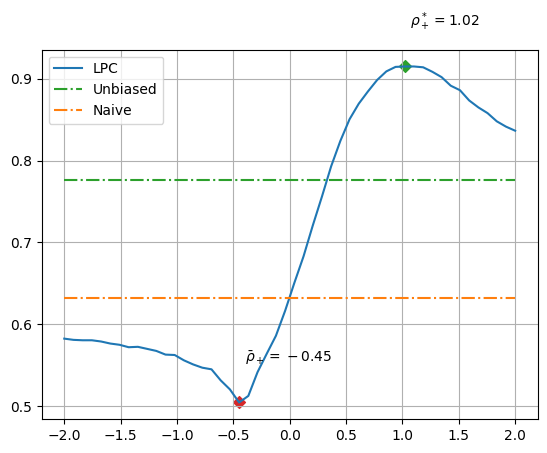

In [7]:
plt.plot(rhops, accs, color = 'tab:blue', label = 'LPC')

x_max, y_max = rhops[np.argmax(accs)], np.max(accs)
x_min, y_min = rhops[np.argmin(accs)], np.min(accs)
plt.scatter(x_max, y_max, color = 'tab:green', marker = 'D')
plt.scatter(x_min, y_min, color = 'tab:red', marker = 'D')
sentence_max = f'$\\rho_+^*= {round(x_max, 2)}$'
sentence_min = f'$\\bar \\rho_+= {round(x_min, 2)}$'
plt.text(x_max+ 5e-2, y_max+ 5e-2, sentence_max)
plt.text(x_min+ 5e-2, y_min+ 5e-2, sentence_min)

# Unbiased
w_unb, l = grad_descent(X, y, lr, gamma, epsp, epsm, 200)
acc_unb = accuracy(decision(w_unb, X_test), y_test)
plt.plot([rhops[0], rhops[-1]], [acc_unb, acc_unb], '-.', color = 'tab:green', label = 'Unbiased')

# Naive
w_naive, l = grad_descent(X, y, lr, gamma, 0, 0, N)
acc_naive = accuracy(decision(w_naive, X_test), y_test)
plt.plot([rhops[0], rhops[-1]], [acc_naive, acc_naive], '-.', color = 'tab:orange', label = 'Naive')
plt.grid()
plt.legend()
plt.show()
